![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error as MSE


# Import any additional modules and start coding below

#Seed = 9 for reproducibility
SEED = 9

# Loading and examining the dataset
df = pd.read_csv("rental_info.csv", parse_dates=["rental_date", "return_date"])
# df.head()
# df.columns
# df.info()


# Getting the number of rental days.
df["rental_length_days"] = (df["return_date"] - df["rental_date"]).dt.days

# Adding dummy variables using the special features column.

df["deleted_scenes"] = np.where(df["special_features"].str.contains("Deleted Scenes"),1,0)
df["behind_the_scenes"] = np.where(df["special_features"].str.contains("Behind the Scenes"),1,0)

df["behind_the_scenes"].value_counts()
df["deleted_scenes"].value_counts()

0    7973
1    7888
Name: deleted_scenes, dtype: int64

In [7]:
# Executing a train-test 

# Only numeric data:
#df.info()
X = df.drop(["rental_length_days","special_features","rental_date", "return_date"], axis = 1)
y = df["rental_length_days"]
features = X.columns

# Spliting the data:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

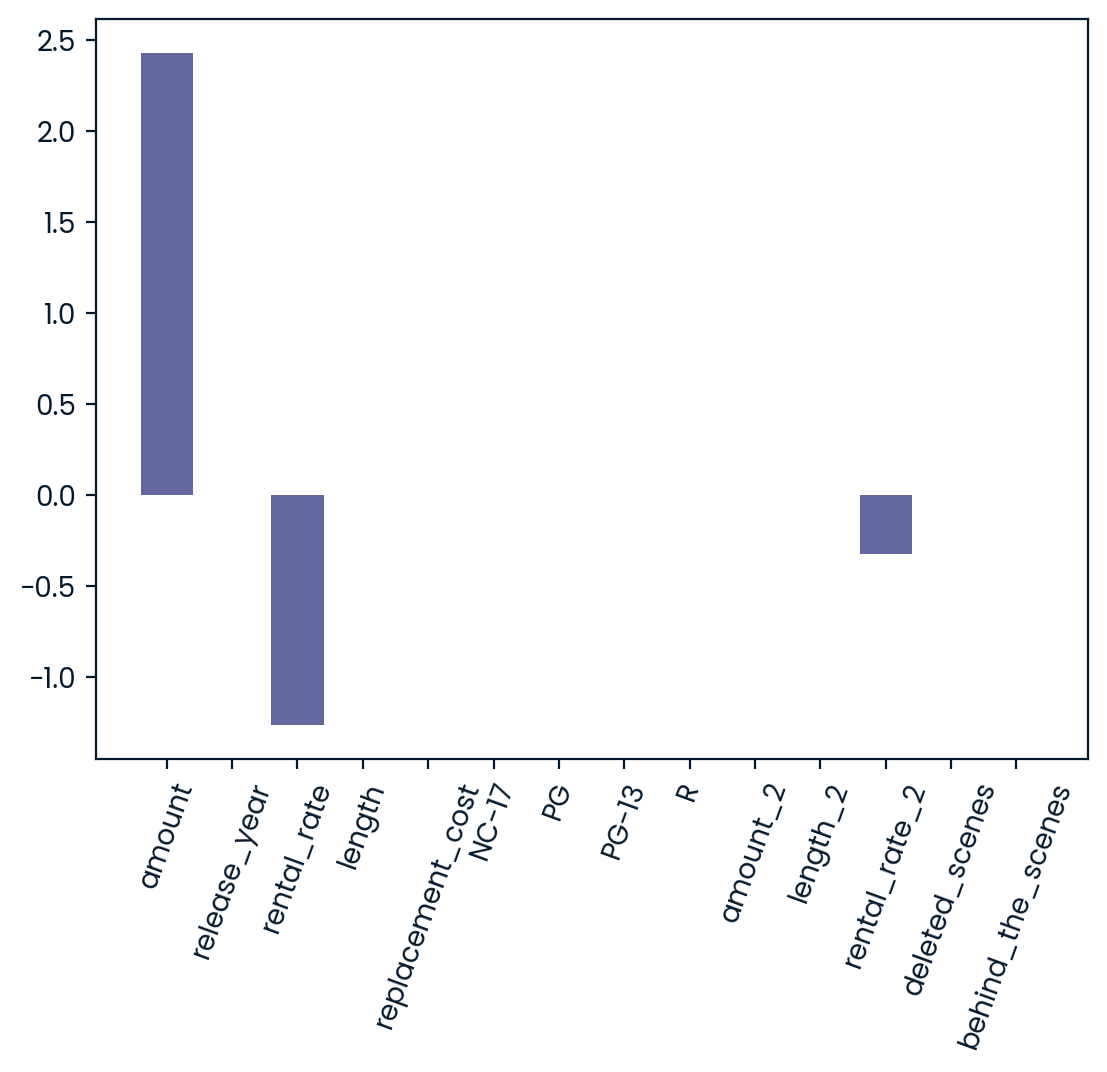

In [8]:
# Performing feature selection: (which feature is the best predictor using Lasso Regression)
lasso = Lasso(alpha = 0.1)
lasso_coef = lasso.fit(X_train_scaled,y_train).coef_

plt.bar(features,lasso_coef)
plt.xticks(rotation=70)
plt.show()

#based on tha bar plot the best_predictor is "amount"

In [4]:
# Choosing models and performing hyperparameter tuning

# :(
#LinearRegression,Ridge, DecisionTreeRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def FineTune_predict_eval(model_name, model, grid_params, X_tr, X_te):
    grid_m = GridSearchCV(model, grid_params, cv=5, scoring='neg_mean_squared_error')
    grid_m.fit(X_tr, y_train)
    
    y_pred = grid_m.predict(X_te)
    rmse = MSE(y_test, y_pred)**(1/2)
    return (grid_m.best_estimator_, rmse)

    




models= {"legre":LinearRegression(),
         "regid": Ridge(),
         "D_Tree": DecisionTreeRegressor(random_state = SEED),
         "R_forest": RandomForestRegressor(random_state = SEED)}

results = dict()

for m_name,model in models.items():
    #No fine tuning needed:    if m_name == "legre":

    if m_name == "regid":
        grid_params = {
            "alpha" : [0.01, 0.1, 1, 10, 100]
        }

        X_tr = X_train_scaled
        X_te = X_test_scaled

    elif m_name == "D_Tree":
        grid_params = {
            'max_depth':[None, 3, 5, 10, 20],
            'min_samples_split':[2, 5, 10],
            'min_samples_leaf':[1, 2, 4],
        }
        
        X_tr = X_train
        X_te = X_test

    else:
        grid_params = {
            'n_estimators':[50, 100, 200],
            'max_depth':[None, 5, 10, 20],
            'min_samples_split':[2, 5, 10],
            'min_samples_leaf':[1, 2, 4],
            'max_features':['auto','sqrt'],
            'n_jobs': [-1]
        }
        
        X_tr = X_train
        X_te = X_test

    if m_name != "legre":
        new_model, rmse = FineTune_predict_eval(m_name, model, grid_params,X_tr, X_te)
    else:
        #new_model stays the same:
        new_model = models["legre"]
        model.fit(X_train_scaled,y_train)
        y_pred = model.predict(X_test_scaled)
        rmse = MSE(y_test, y_pred)**(1/2)
        
    models[m_name] = new_model
    results[m_name] = (new_model,rmse)

best_model_name = min(results, key=lambda resName: results[resName][1] ) #key = a function that converts elements into a value that is used for comparison.
best_model, best_mse = results[best_model_name]
best_mse = best_mse**2
        
    
